40960/30286 [========================================] - 0s 3us/step
/root/.keras/datasets/auto-mpg.data
      MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[5 rows x 8 columns]
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
              count         mean         std  ...     50%      75%     max
Cylinders     314.0     5.477707    1.699788  ...     4.0     8.00     8.0
Displacement  314.0   195.318471  104.331589  ...   151.0   265.75   455.0
Horsepower    314.0   104.869427   38.096214  .

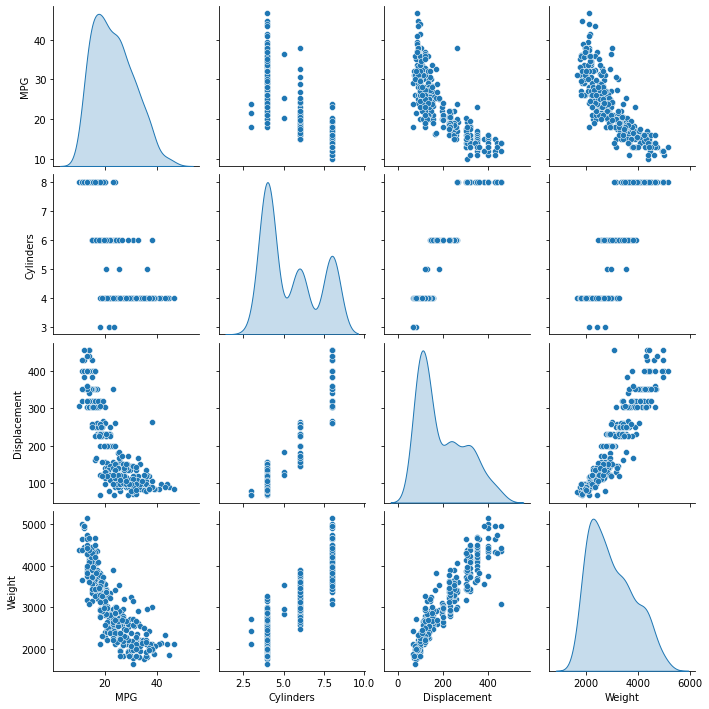

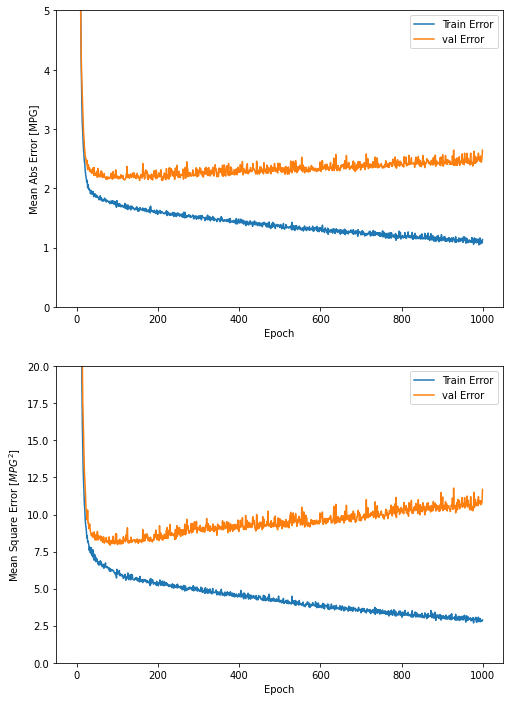


............

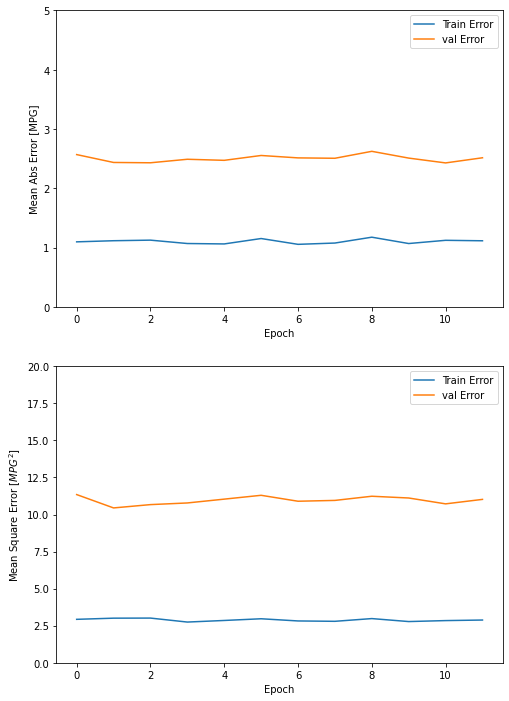

실제 최소 = 11.127469, 실제 최대 = 39.679485, 오차 평균 = 2.295227
예상 최소 = 9.000000, 예상 최대 = 44.300000


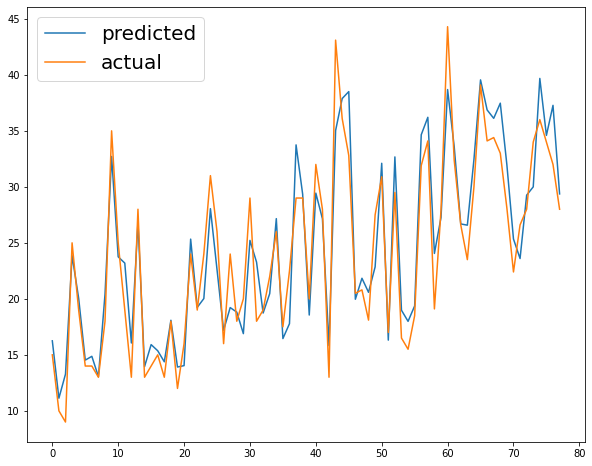

In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#데이터셋은 UCI 머신 러닝 저장소에서 다운로드
dataset_path = keras.utils.get_file("auto-mpg.data",
                                   "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model Year', 'Origin']    #MPG가 연비

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t",
                         sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
print(dataset.tail())

#칼럼별 결측값 개수 구하기 : df.isnull().sum()    (isnull()과 isna() 동일 의미 사용)
print(dataset.isnull().sum())

#문제를 간단하게 만들기 위해서 누락된 행을 삭제
dataset = dataset.dropna()

#항목중 Origin이 원산지인데 수치형이 아니고 범주형이므로 원한인코딩으로 변환
#1,2,3을 1.0 0.0 0.0 / 0.0 1.0 0.0 / 0.0 0.0 1.0 형태로 변환
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japen'] = (origin == 3) * 1.0
dataset.tail()

#학습셋 검증셋 분리
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#data확인(훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 작성)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

#================이 위쪽은 어제거에 주석 참고할것(너무 많아져서 생략했음)================

#통계적인 확인
#describe()함수를 사용하면 수치형 변수들만을 기준으로 카운트, 평균, 표준편차,
#최소/최댓값, 4분위 수를 기준으로 25%, 50%, 75%에 해당하는 값들을 테이블로 출력해준다
#데이터의 개수(count), 데이터의 평균값(mean), 표준편차(std), 최솟값(min),
#4분위수(25%, 50%, 75%), 그리괴 최댓값(max)들의 정보를 알 수 있음
train_stats = train_dataset.describe()
train_stats.pop("MPG")
#그룹 별 기술통계량 - 옆으로 길게 표시
train_stats = train_stats.transpose()
print(train_stats)

#특성에서 타깃 값 또는 "레이블"을 분리. 이 레이블을 예측하기 위해 모델을 훈련시킴
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

#data 정규화 함수 정의
def norm(x):
    #(X - 평균) / 표준편차 - Z-Score Normalizetion(Z-점수 정규화)
    return (x - train_stats['mean']) / train_stats['std']

#train_dataset과 test_dataset을 분류
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#모델 만들기
model = tf.keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))
optimizer = tf.keras.optimizers.RMSprop(0.001)
#측정항목 함수는 loss function와 비슷하지만, 측정항목을 평가한 결과는 모델을 학습시키는데
#사용되지 않는다는 점에서 다름. MSE(mean squared error)와 MAX(mean absolute error)를 평가
model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])

#Model을 확인해 봄 가중치와 바이어스가 초기값(랜던값)인 모델
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

#에포크가 끝날때마다 점(.)을 출력해 훈련 진행 과정을 표시
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100 == 0:
            print('')
        print('.', end='')
EPOCHS = 1000

#입력값을 필히 정규화된 값으로 넣어줘야 함
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(8,12))
    
    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='val Error')
    plt.ylim([0, 5])    #y축 범위 설정
    #그래프 영역에 범례(legend)를 나타내기 위해서는 우선 plot() 함수에 label문자열을 지정하고,
    # matplotlib.pyplot 모듈의 legend()함수를 호출
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    #달러기호($) 사이에 위치하는 TeXt 마크업 표현을 통해 Matplotlib에서 수학적 표현을 사용
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='val Error')
    plt.ylim([0, 20])    #y축 범위 설정
    plt.legend()
    
    plt.show()
    
plot_history(history)

#patience 매개변수는 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

#예측값과 실제값을 비교하여 그래프로 확인
Y_prediction = model.predict(normed_test_data).flatten()
plt.figure(figsize=(10,8))
plt.plot(Y_prediction, label = 'predicted')
plt.plot(test_labels.values, label = 'actual')
plt.legend(prop={'size':20})

#예측값과 실제값 오차 평균을 측정
avr = abs(Y_prediction - test_labels).mean()
print("실제 최소 = %f, 실제 최대 = %f, 오차 평균 = %f" %(min(Y_prediction), max(Y_prediction),avr))
print("예상 최소 = %f, 예상 최대 = %f" %(min(test_labels), max(test_labels)))